### Setup + Read Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2022-12-21 16:25:50.319362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Get data (only do this once!)
!wget https://dqanonymousdata.blob.core.windows.net/neurips-public/data.zip
!unzip data.zip

In [2]:
# Create Data-frames
BASE, EXT = 'data/metadata/', '_task_1_2.csv'
TRAIN = pd.read_csv('data/train_data/train' + EXT)
SUBJECT = pd.read_csv(BASE + 'subject_metadata.csv')
QUESTION = pd.read_csv(BASE + 'question_metadata' + EXT)
QUESTION['SubjectId'] = [list(map(int,x[1:-1].split(', '))) for x in QUESTION['SubjectId']]

### Review Data

In [ ]:
# Set DATA variable
DATA = QUESTION

In [ ]:
# Basic information
print('What is the type of the data: ' + str(type(DATA)))
print('Structure of the data: ' + str(DATA.shape))

In [ ]:
# General information
DATA.info()

In [ ]:
# First 5 entries
DATA.head()

### Analysis: Understanding Trends

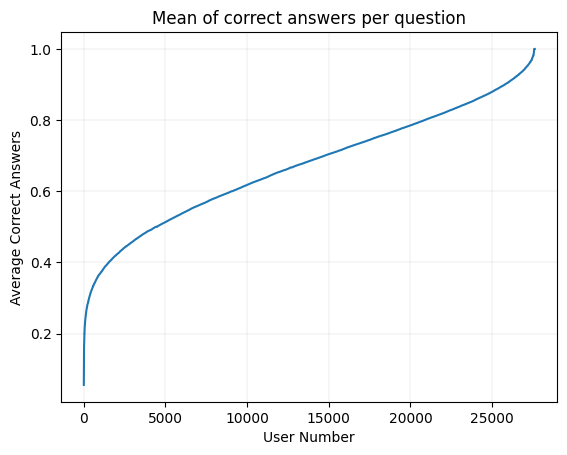

In [3]:
QUESTION_INFO = TRAIN.groupby('QuestionId')['IsCorrect'].agg(['mean', 'count', 'sum'])
QUESTION_INFO = QUESTION_INFO.sort_values(by='mean')
plt.plot(QUESTION_INFO['mean'].values)
plt.title('Mean of correct answers per question')
plt.xlabel('User Number')
plt.ylabel('Average Correct Answers')
plt.grid(color='gray', linestyle='-', linewidth=0.1)
plt.show()

### Prepare the data

In [4]:
# Encode the subjects into each question
subject_map = {x: y for x, y in zip(SUBJECT.SubjectId, SUBJECT.Name)}
QUESTION = QUESTION.join(QUESTION.SubjectId.explode().apply(lambda x: subject_map[x]).str.get_dummies().groupby(level=0).sum().astype(bool))
temp = QUESTION.iloc[0]['SubjectId'] + [1189, 130]
QUESTION = QUESTION.drop(columns=['SubjectId']).set_index('QuestionId')
for x in temp: # Last two should be False
    print(QUESTION[subject_map[x]].iloc[0])

True
True
True
True
True
True
True
True
False
False


In [5]:
# Create STUDENT features (average of correct answers per subject)
STUDENT = TRAIN.groupby('UserId')['IsCorrect'].agg(average='mean', num_questions='count')
for _, x in subject_map.items(): # Takes about 3 minutes
    select = set(QUESTION.loc[QUESTION[x] == True].index.values)
    averages = TRAIN[TRAIN['QuestionId'].isin(select)].groupby('UserId')['IsCorrect'].mean()
    STUDENT = pd.concat((STUDENT, averages), axis=1)
    STUDENT.rename(columns={'IsCorrect': x}, inplace=True)

In [6]:
# High use values
FEATURE_COUNT = len(subject_map)
QUESTION_COUNT = QUESTION.shape[0]
STUDENT_COUNT = STUDENT.shape[0]
print(FEATURE_COUNT, QUESTION_COUNT, STUDENT_COUNT)

388 27613 118971


### Machine Learning: Content-Based Filtering

In [11]:
# SCALE THE DATA

In [7]:
# Create the model
num_outputs = 32
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=num_outputs, activation='sigmoid'),
])
item_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=num_outputs, activation='sigmoid'),
])
# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(FEATURE_COUNT))
vu = tf.linalg.l2_normalize(user_NN(input_user), axis=1)
# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(FEATURE_COUNT))
vm = tf.linalg.l2_normalize(item_NN(input_item), axis=1)
# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])
# specify the inputs and output of the model and compile
model = keras.Model([input_user, input_item], output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy())
model.summary()

2022-12-21 16:32:42.600369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 388)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 388)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           136608      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           136608      ['input_2[0][0]']                
                                                                                              

In [8]:
# Generate Training Data - Kernel Crashes
X_student = TRAIN.join(STUDENT, on='UserId', how='inner', sort=True).iloc[:, 8:]
X_question = TRAIN.join(QUESTION, on='QuestionId', how='inner', sort=True).iloc[:, 6:]
Y = TRAIN['IsCorrect']

: 

: 

In [16]:
# Train the model (takes too much time)
for chunk in np.array_split(TRAIN, 30):
    X_student = chunk.join(STUDENT, on='UserId', how='inner', sort=True).iloc[:, 8:]
    X_question = chunk.join(QUESTION, on='QuestionId', how='inner', sort=True).iloc[:, 6:]
    Y = chunk['IsCorrect']
    model.fit([X_student, X_question], Y, epochs=10)

Epoch 1/10
16530/16530 [==============================] - 144s 9ms/step - loss: nan
Epoch 2/10
16530/16530 [==============================] - 138s 8ms/step - loss: nan
Epoch 3/10
16530/16530 [==============================] - 135s 8ms/step - loss: nan
Epoch 4/10
16530/16530 [==============================] - 145s 9ms/step - loss: nan
Epoch 5/10
16530/16530 [==============================] - 263s 16ms/step - loss: nan
Epoch 6/10
16530/16530 [==============================] - 135s 8ms/step - loss: nan
Epoch 7/10
16530/16530 [==============================] - 137s 8ms/step - loss: nan
Epoch 8/10
16530/16530 [==============================] - 1674s 101ms/step - loss: nan
Epoch 9/10
16530/16530 [==============================] - 251s 15ms/step - loss: nan
Epoch 10/10
16530/16530 [==============================] - 163s 10ms/step - loss: nan
Epoch 1/10
16530/16530 [==============================] - 137s 8ms/step - loss: nan
Epoch 2/10
16530/16530 [==============================] - 130s 8ms/st